In [38]:
!pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable


In [39]:
from torchvision import datasets, transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance de voltear
    transforms.RandomCrop(32, padding=4),     # Recortar aleatoriamente
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Variar brillo/contraste
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar a [-1, 1]
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Misma normalización
])

train_data = datasets.CIFAR10(root="./cifar10",
                                train=True,
                                download=True,
                                transform=train_transform)

test_data = datasets.CIFAR10(root="./cifar10",
                                train=False,
                                download=True,
                                transform=test_transform)


Files already downloaded and verified
Files already downloaded and verified


In [40]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [41]:
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

#ver un batch
images, labels = next(iter(train_loader))
print(f"Batch Shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Training samples: 50000
Test samples: 10000
Batch Shape: torch.Size([32, 3, 32, 32])
Labels shape: torch.Size([32])


In [42]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, #porque son 3 canales RGB 
                                out_channels=32,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, 
                                out_channels=64,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2,
                                stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, 
                                out_channels=128,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, 
                                out_channels=256,
                                kernel_size=3,
                                stride=1,
                                padding=1)

        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(in_channels=256, 
                                out_channels=512,
                                kernel_size=3,
                                stride=1,
                                padding=1)

        self.bn5 = nn.BatchNorm2d(512)

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features=512*4*4,
                            out_features=10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.flatten(start_dim=1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

model = CIFAR10Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
torch.manual_seed(42)

epochs = 30

train_loss_values = []
test_loss_values = []
test_accuracy_values = []
epoch_count =[]

for epoch in range(epochs):
    epoch_count.append(epoch)
    
    model.train()
    train_loss = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)
    
    # ========== EVALUACIÓN ==========
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()
            
            _, predicted = output.max(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_test_loss = test_loss / len(test_loader)
    test_loss_values.append(avg_test_loss)
    
    accuracy = 100 * correct / total
    test_accuracy_values.append(accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1/30, Train Loss: 1.6488, Test Loss: 0.9887, Accuracy: 64.39%
Epoch 2/30, Train Loss: 1.0060, Test Loss: 0.8165, Accuracy: 70.65%
Epoch 3/30, Train Loss: 0.8379, Test Loss: 0.7057, Accuracy: 75.83%
Epoch 4/30, Train Loss: 0.7484, Test Loss: 0.6630, Accuracy: 77.83%
Epoch 5/30, Train Loss: 0.6633, Test Loss: 0.5693, Accuracy: 80.68%
Epoch 6/30, Train Loss: 0.6126, Test Loss: 0.5168, Accuracy: 82.30%
Epoch 7/30, Train Loss: 0.5651, Test Loss: 0.5083, Accuracy: 83.45%
Epoch 8/30, Train Loss: 0.5252, Test Loss: 0.4895, Accuracy: 83.94%
Epoch 9/30, Train Loss: 0.4939, Test Loss: 0.4876, Accuracy: 84.16%
Epoch 10/30, Train Loss: 0.4689, Test Loss: 0.4252, Accuracy: 85.43%
Epoch 11/30, Train Loss: 0.4391, Test Loss: 0.4094, Accuracy: 86.35%
Epoch 12/30, Train Loss: 0.4224, Test Loss: 0.4368, Accuracy: 85.58%
Epoch 13/30, Train Loss: 0.4025, Test Loss: 0.3857, Accuracy: 87.44%
Epoch 14/30, Train Loss: 0.3834, Test Loss: 0.3885, Accuracy: 87.46%
Epoch 15/30, Train Loss: 0.3688, Test Loss:

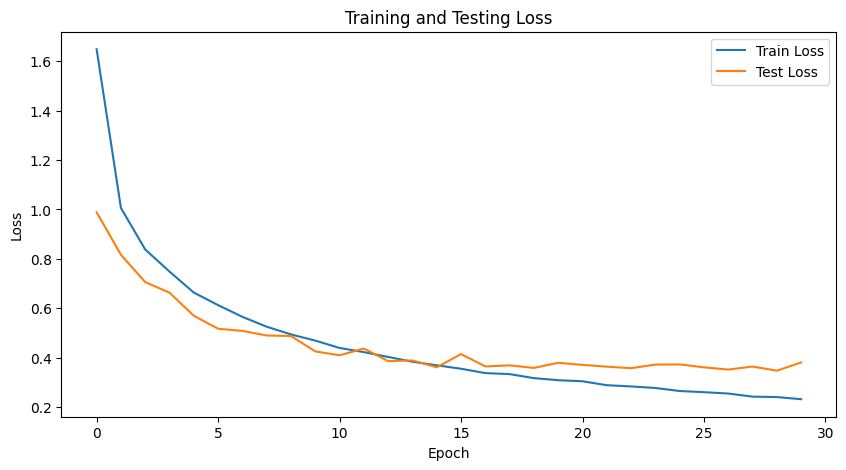

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()